In [1]:
# Imports and Setup
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# GPU Check
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("WARNING: No GPU detected. Training will be on CPU.")


Num GPUs Available: 1
GPU is available.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset shape: (3662, 2)
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
Missing values per column:
id_code      0
diagnosis    0
dtype: int64


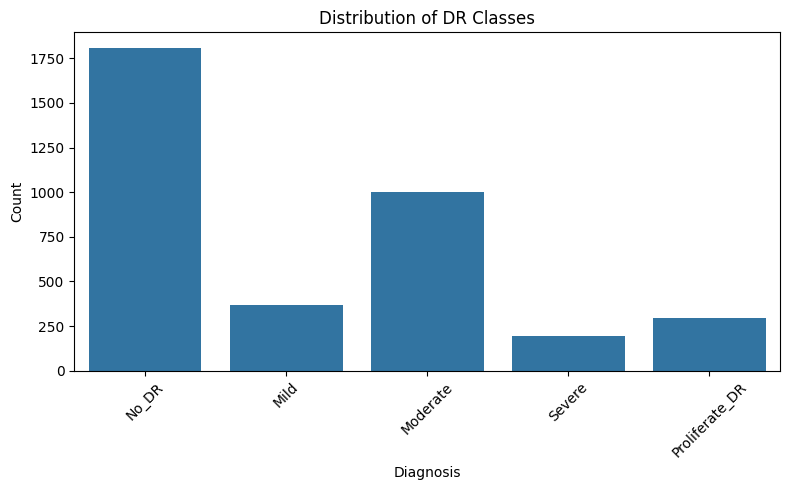

In [3]:
# Load the CSV file containing your metadata
df = pd.read_csv('/content/drive/MyDrive/BELL_GRAHAM_FILTERDATA/train.csv')  # Ensure 'train.csv' is in the working directory
print("Dataset shape:", df.shape)
print(df.head())

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Map diagnosis to class names
diagnosis_mapping = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR'
}
df['class_name'] = df['diagnosis'].map(diagnosis_mapping)

# Plot class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='class_name', data=df, order=list(diagnosis_mapping.values()))
plt.title("Distribution of DR Classes")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
# Construct image paths (assumes images are stored in folders named after each class)
base_dir = '/content/drive/MyDrive/BELL_GRAHAM_FILTERDATA'  # Confirm this folder exists with subfolders per class
df['image_path'] = df.apply(lambda row: os.path.join(base_dir, row['class_name'], f"{row['id_code']}.png"), axis=1)

# Verify that every image exists
if not df['image_path'].apply(os.path.exists).all():
    missing = df[~df['image_path'].apply(os.path.exists)]
    print(f"ERROR: {len(missing)} images are missing!")
    print(missing[['id_code', 'image_path']])
    raise FileNotFoundError("Missing images. Please fix the paths.")
else:
    print("All images found.")


All images found.


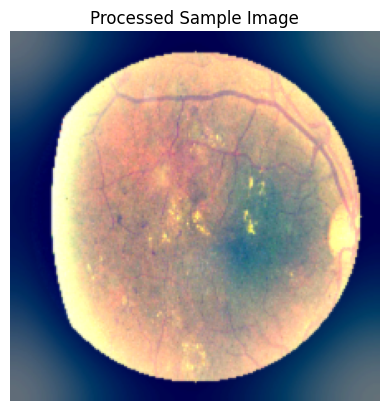

In [5]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Basic preprocessing:
      - Read the image.
      - Resize.
      - Convert BGR to RGB.
      - Normalize pixel values to [0,1].
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image at {image_path}")
        return None
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    return img

# Test the preprocessing function
sample_img = preprocess_image(df['image_path'].iloc[0])
if sample_img is not None:
    plt.imshow(sample_img)
    plt.title("Processed Sample Image")
    plt.axis('off')
    plt.show()
else:
    print("Preprocessing failed for the sample image.")


In [6]:
# Set up ImageDataGenerators using basic augmentation since images are preprocessed
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

# Validation/test generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1/255.0)

# Create a new column as string for flow_from_dataframe
df['diagnosis_str'] = df['diagnosis'].astype(str)

# Split data (stratified split)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['diagnosis_str'],
    random_state=42
)

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='diagnosis_str',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='diagnosis_str',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='diagnosis_str',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights to help address imbalance
classes = train_df['diagnosis'].values
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)
class_weights = {i: cw_val for i, cw_val in enumerate(cw)}
print("Class weights:", class_weights)


Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Class weights: {0: 0.4056786703601108, 1: 1.979054054054054, 2: 0.7331664580725907, 3: 3.803896103896104, 4: 2.4822033898305085}


In [7]:
def build_model(num_classes=5, fine_tune=False, fine_tune_at=100):
    """
    Build a model based on ResNet50V2.
    If fine_tune is True, layers before `fine_tune_at` are frozen.
    """
    base_model = applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = fine_tune  # Initially freeze if not fine-tuning

    if fine_tune:
        # Freeze early layers and unfreeze later layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Build the model (initially with frozen base)
model = build_model(fine_tune=False)
model.summary()


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,196,485 (99.93 MB)

 Trainable params: 2,628,613 (10.03 MB)

 Non-trainable params: 23,567,872 (89.90 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.4286 - loss: 2.2779 

74/74 ━━━━━━━━━━━━━━━━━━━━ 1762s 24s/step - accuracy: 0.4292 - loss: 2.2763 - val_accuracy: 0.4974 - val_loss: 1.3900 - learning_rate: 0.0010
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.5358 - loss: 1.7445

74/74 ━━━━━━━━━━━━━━━━━━━━ 63s 751ms/step - accuracy: 0.5358 - loss: 1.7439 - val_accuracy: 0.5470 - val_loss: 1.1858 - learning_rate: 0.0010
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 759ms/step - accuracy: 0.5490 - loss: 1.5421 - val_accuracy: 0.5470 - val_loss: 1.2699 - learning_rate: 0.0010
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.5738 - loss: 1.4175

74/74 ━━━━━━━━━━━━━━━━━━━━ 83s 780ms/step - accuracy: 0.5739 - loss: 1.4178 - val_accuracy: 0.6137 - val_loss: 0.9858 - learning_rate: 0.0010
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.5661 - loss: 1.3289

74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 758ms/step - accuracy: 0.5661 - loss: 1.3292 - val_accuracy: 0.6427 - val_loss: 0.9004 - learning_rate: 0.0010
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 66s 890ms/step - accuracy: 0.6135 - loss: 1.2858 - val_accuracy: 0.6017 - val_loss: 1.0020 - learning_rate: 0.0010
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 55s 751ms/step - accuracy: 0.6068 - loss: 1.2328 - val_accuracy: 0.5487 - val_loss: 1.1460 - learning_rate: 0.0010
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 775ms/step - accuracy: 0.6057 - loss: 1.2513 - val_accuracy: 0.6085 - val_loss: 0.9340 - learning_rate: 0.0010
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.5832 - loss: 1.1587

74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 760ms/step - accuracy: 0.5835 - loss: 1.1588 - val_accuracy: 0.6291 - val_loss: 0.8521 - learning_rate: 2.0000e-04
Epoch 10/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.6144 - loss: 1.1784

74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 763ms/step - accuracy: 0.6145 - loss: 1.1781 - val_accuracy: 0.6393 - val_loss: 0.8469 - learning_rate: 2.0000e-04
Epoch 11/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.6282 - loss: 1.1888

74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 754ms/step - accuracy: 0.6283 - loss: 1.1876 - val_accuracy: 0.6513 - val_loss: 0.8046 - learning_rate: 2.0000e-04
Epoch 12/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 91s 890ms/step - accuracy: 0.6380 - loss: 1.0834 - val_accuracy: 0.6838 - val_loss: 0.8086 - learning_rate: 2.0000e-04
Epoch 13/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 55s 747ms/step - accuracy: 0.6290 - loss: 1.1020 - val_accuracy: 0.6444 - val_loss: 0.8308 - learning_rate: 2.0000e-04
Epoch 14/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 755ms/step - accuracy: 0.6353 - loss: 1.1059 - val_accuracy: 0.6598 - val_loss: 0.8219 - learning_rate: 2.0000e-04
Epoch 15/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 55s 750ms/step - accuracy: 0.6357 - loss: 1.0961 - val_accuracy: 0.6359 - val_loss: 0.8321 - learning_rate: 4.0000e-05
Epoch 16/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 768ms/step - accuracy: 0.6430 - loss: 1.0306 - val_accuracy: 0.6547 - val_loss: 0.8364 - learning_rate: 4.0000e-05
Epoch 17/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 761ms/step - accuracy

74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 762ms/step - accuracy: 0.6557 - loss: 1.0117 - val_accuracy: 0.6632 - val_loss: 0.7989 - learning_rate: 8.0000e-06
Epoch 19/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 55s 745ms/step - accuracy: 0.6590 - loss: 1.1305 - val_accuracy: 0.6513 - val_loss: 0.8074 - learning_rate: 8.0000e-06
Epoch 20/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.6536 - loss: 1.0525

74/74 ━━━━━━━━━━━━━━━━━━━━ 58s 788ms/step - accuracy: 0.6537 - loss: 1.0525 - val_accuracy: 0.6769 - val_loss: 0.7837 - learning_rate: 8.0000e-06


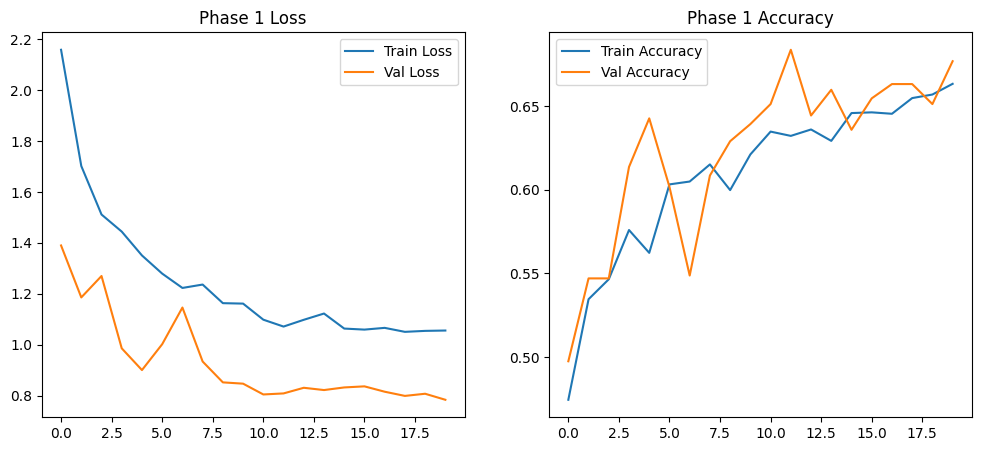

In [8]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_path = 'model_phase1_best_bell_graham.h5'
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

epochs_phase1 = 20
history_phase1 = model.fit(
    train_generator,
    epochs=epochs_phase1,
    validation_data=validation_generator,
    callbacks=callbacks_phase1,
    class_weight=class_weights  # Use class weights to help imbalanced classes
)

# Plot training history (Phase 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_phase1.history['loss'], label='Train Loss')
plt.plot(history_phase1.history['val_loss'], label='Val Loss')
plt.title("Phase 1 Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_phase1.history['accuracy'], label='Train Accuracy')
plt.plot(history_phase1.history['val_accuracy'], label='Val Accuracy')
plt.title("Phase 1 Accuracy")
plt.legend()
plt.show()


Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.5826 - loss: 1.2928

74/74 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.5828 - loss: 1.2928 - val_accuracy: 0.6821 - val_loss: 1.0941 - learning_rate: 1.0000e-04
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.6187 - loss: 1.1327

74/74 ━━━━━━━━━━━━━━━━━━━━ 58s 782ms/step - accuracy: 0.6188 - loss: 1.1322 - val_accuracy: 0.7282 - val_loss: 0.7396 - learning_rate: 1.0000e-04
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 82s 777ms/step - accuracy: 0.6779 - loss: 1.0479 - val_accuracy: 0.6684 - val_loss: 0.8041 - learning_rate: 1.0000e-04
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.6670 - loss: 0.9583

74/74 ━━━━━━━━━━━━━━━━━━━━ 58s 785ms/step - accuracy: 0.6670 - loss: 0.9585 - val_accuracy: 0.7009 - val_loss: 0.7269 - learning_rate: 1.0000e-04
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 765ms/step - accuracy: 0.6962 - loss: 0.9216 - val_accuracy: 0.6889 - val_loss: 0.7446 - learning_rate: 1.0000e-04
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 58s 784ms/step - accuracy: 0.6721 - loss: 0.9268 - val_accuracy: 0.6803 - val_loss: 0.8162 - learning_rate: 1.0000e-04
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 775ms/step - accuracy: 0.7135 - loss: 0.8760 - val_accuracy: 0.6974 - val_loss: 0.7494 - learning_rate: 1.0000e-04
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.7214 - loss: 0.8465

74/74 ━━━━━━━━━━━━━━━━━━━━ 58s 789ms/step - accuracy: 0.7215 - loss: 0.8461 - val_accuracy: 0.7162 - val_loss: 0.6702 - learning_rate: 2.0000e-05
Epoch 9/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 58s 769ms/step - accuracy: 0.7309 - loss: 0.7909 - val_accuracy: 0.7265 - val_loss: 0.6800 - learning_rate: 2.0000e-05
Epoch 10/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 756ms/step - accuracy: 0.7415 - loss: 0.8123 - val_accuracy: 0.7231 - val_loss: 0.6726 - learning_rate: 2.0000e-05
Epoch 11/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 775ms/step - accuracy: 0.7535 - loss: 0.7139 - val_accuracy: 0.7368 - val_loss: 0.6919 - learning_rate: 2.0000e-05
Epoch 12/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 762ms/step - accuracy: 0.7676 - loss: 0.7058 - val_accuracy: 0.7573 - val_loss: 0.6866 - learning_rate: 4.0000e-06
Epoch 13/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 761ms/step - accuracy: 0.7954 - loss: 0.6363 - val_accuracy: 0.7128 - val_loss: 0.6906 - learning_rate: 4.0000e-06
Epoch 14/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 55s 745ms/step - accuracy:

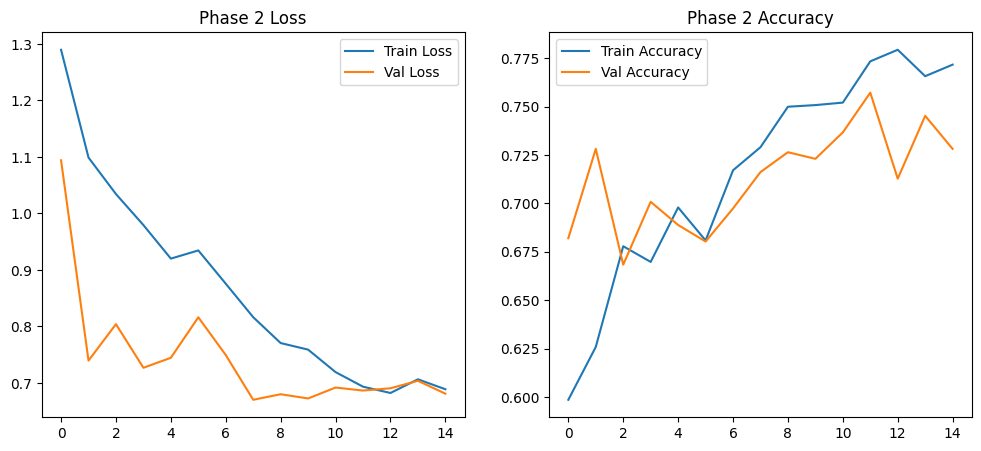

In [9]:
# Load best weights from phase 1
model.load_weights(checkpoint_path)

# Build a fine-tuning model
model_ft = build_model(fine_tune=True, fine_tune_at=100)
# Transfer weights from the phase 1 model
model_ft.set_weights(model.get_weights())

model_ft.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path_ft = 'model_phase2_best_bell_graham.h5'
callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint(checkpoint_path_ft, monitor='val_loss', save_best_only=True)
]

epochs_phase2 = 15
history_phase2 = model_ft.fit(
    train_generator,
    epochs=epochs_phase2,
    validation_data=validation_generator,
    callbacks=callbacks_phase2,
    class_weight=class_weights
)

# Plot training history (Phase 2)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_phase2.history['loss'], label='Train Loss')
plt.plot(history_phase2.history['val_loss'], label='Val Loss')
plt.title("Phase 2 Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_phase2.history['accuracy'], label='Train Accuracy')
plt.plot(history_phase2.history['val_accuracy'], label='Val Accuracy')
plt.title("Phase 2 Accuracy")
plt.legend()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 404s 18s/step - accuracy: 0.7468 - loss: 0.6629
Test Accuracy: 0.7285
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 379ms/step
Classification Report:
                precision    recall  f1-score   support

         No_DR       0.96      0.95      0.95       361
          Mild       0.39      0.61      0.47        74
      Moderate       0.71      0.49      0.58       200
        Severe       0.31      0.69      0.43        39
Proliferate_DR       0.62      0.34      0.44        59

      accuracy                           0.73       733
     macro avg       0.60      0.62      0.58       733
  weighted avg       0.77      0.73      0.73       733



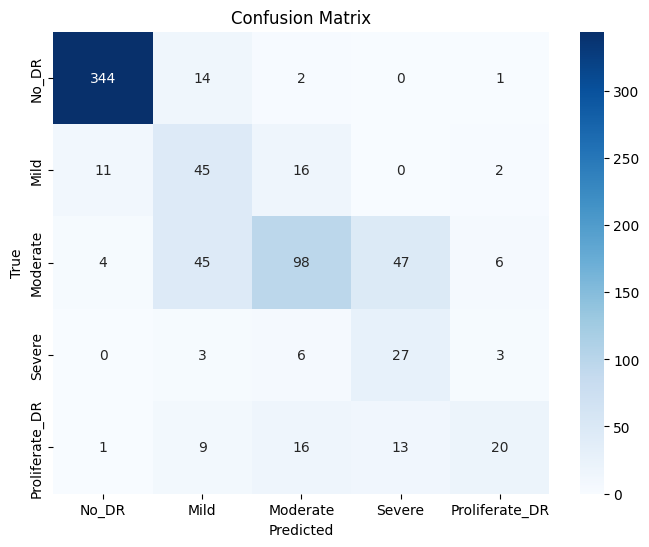

In [10]:
test_loss, test_accuracy = model_ft.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = model_ft.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(diagnosis_mapping.values())))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=diagnosis_mapping.values(), yticklabels=diagnosis_mapping.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Class: Proliferate_DR
Confidence: 0.4249
Class Probabilities: {'No_DR': 1.1517332e-06, 'Mild': 0.002942882, 'Moderate': 0.3681463, 'Severe': 0.20400639, 'Proliferate_DR': 0.42490327}


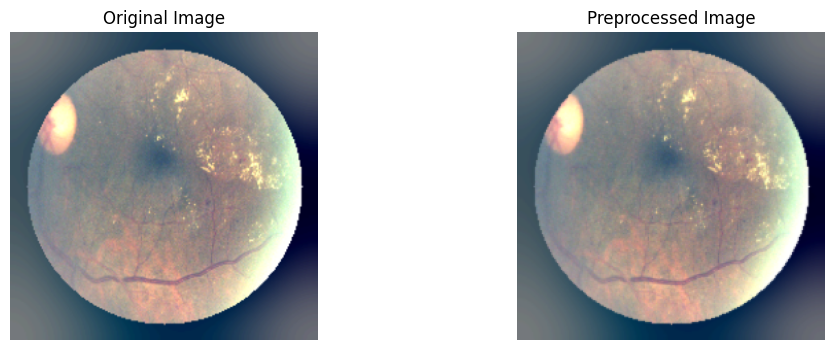

In [13]:
from tensorflow.keras.models import load_model

# Load your model from the file
model_ft = load_model('model_phase2_best_bell_graham.h5')

def predict_image(image_path, model):
    """
    Predicts the class of a single image.
    Returns a dictionary with:
      - 'predicted_class'
      - 'confidence'
      - 'probabilities'
      - 'preprocessed_image'
    """
    img = preprocess_image(image_path)
    if img is None:
        return None
    img_batch = np.expand_dims(img, axis=0)
    predictions = model.predict(img_batch)
    predicted_class_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_index]
    return {
        'predicted_class': diagnosis_mapping[predicted_class_index],
        'confidence': confidence,
        'probabilities': dict(zip(diagnosis_mapping.values(), predictions[0])),
        'preprocessed_image': img
    }

# Test prediction on a sample test image
# sample_image_path = test_df['image_path'].iloc[0]
sample_image_path ='/content/drive/MyDrive/BELL_GRAHAM_FILTERDATA/Moderate/033f2b43de6d.png'
result = predict_image(sample_image_path, model_ft)
if result:
    print(f"Predicted Class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("Class Probabilities:", result['probabilities'])

    # Display original and preprocessed image side by side
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    orig_img = cv2.cvtColor(cv2.imread(sample_image_path), cv2.COLOR_BGR2RGB)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(result['preprocessed_image'])
    plt.title("Preprocessed Image")
    plt.axis('off')
    plt.show()
else:
    print("Prediction failed.")


In [15]:
# Save the model
model_save_path = 'diabetic_retinopathy_bell_graham_model_final_v2.keras'
model_ft.save(model_save_path)
print(f"Model saved to {model_save_path}")

def load_trained_model(model_path):
    """Loads a saved Keras model."""
    return tf.keras.models.load_model(model_path)

# Test loading the model
loaded_model = load_trained_model(model_save_path)
loaded_result = predict_image(sample_image_path, loaded_model)
if loaded_result:
    print("Loaded Model Prediction:", loaded_result['predicted_class'])


Model saved to diabetic_retinopathy_bell_graham_model_final_v2.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 186 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Loaded Model Prediction: Proliferate_DR
